# **Module 2 Workbook: Understanding and Interpreting AI Tools**


## Required python packages and data/model directories

In [ ]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
from google.colab import drive
import os
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

drive.mount('/content/drive')

##### option to host the data and the model on github so we have better control over the directory - thoughts??

#The following two lines of code loads the deep learning model we will be testing and the dataset we will be using to test it on
#The file path to this model and the dataset should align with your google drive
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Melanoma-003.keras") #model directory
test_dir = '/content/drive/MyDrive/Colab Notebooks/train_cancer' #data directory

Mounted at /content/drive


## Required functions for image processing

In [ ]:
def preprocess_image(img_path):
    from tensorflow.keras.preprocessing import image
    import numpy as np

    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

## Classifying Melanoma Using an AI Model

As nurse scientists it is essential to be able to both develop and evaluate complex models that may be used to improve patient care. In this workbook we will calculate and interpret the various performance metrics discussed throughout this module using a pre-trained model hosted on **Hugging Face**. Hugging Face is an online platform where users can upload, find and download pre-trained AI models for tasks ranging from image classification to text generation. For the purpose of this example, we will be using a pre-trained model hosted on Hugging Face developed for melanoma detection using image pattern recognization.

The model we will be evaluating was developed by the user `lizardwine`to detect melanoma from skin lesion images. It works by processing an input image (size 224x224) pixels and outputs a binary classification indicting whether the lesion is cancerous or not. The model is trained to discriminate between malignant and bengign moles.

**Model information**:
https://huggingface.co/lizardwine/Melanoma-003
*   Model type: Convolutional Neural Network (CNN)
*   Trained on Skin Dataset: https://www.kaggle.com/datasets/shashanks1202/skin-cancer-dataset
*   Input: 224x224 RBG images of skin lesions
*   Output: A binary classification (Melanoma or Not Melanoma)
*   Purpose: To identify and classify skin lesions as melanoma or non-melanoma with "high accuracy".

**Testing Dataset information**:
*   This dataset contains images of skin lesions categorized into two cases: malignant and benign. It is organized in two folders. This dataset is from the https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign. All the rights of the Data are bound to the ISIC-Archive rights (https://www.isic-archive.com/#!/topWithHeader/wideContentTop/main).
*   Malignant: This folder contains images of skin lesions that have been diagnosed as malignant.
*   Benign: this folder includes images of benign skins lesions, which are non-cancerous.





## **Problem 0**: Evaluation Bias

As we learned Module 2, evaluation bias occurs when the data used to train a model doesn't accurately represent the real world, leading to inaccurate prediction and an overestimation of model performance metrics. Therefore it is useful to validate performance metrics of a model on data that it has never seen before.

The developer of this melanoma classification models claims it performs with ~99% accuracy on the dataset that it was trained on. Let's see how it does on new data that it has never seen before! We will use the model to predict melanoma and compare the models predictions to the images' actual labels.



### a. Displaying a Single Image

First lets just take a look at a single image in benign group and the malignant group to get a better sense of what the model is using as input data and making a prediction about.

The code below displays a single image in the benign folder and the model's prediction of the lesions (melanoma or not melanoma).

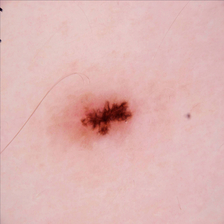

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
The lesion is classified as Not Melanoma.


In [ ]:
from IPython.display import Image, display

# Example usage for a mole we know is benign
img_path = '/content/drive/MyDrive/Colab Notebooks/train_cancer/benign/1.jpg'
processed_image = preprocess_image(img_path)
display(Image(img_path))

# Predict the class
prediction = model.predict(processed_image)

# Interpret the result
if prediction[0] > 0.5:
    print('The lesion is classified as Melanoma.')
else:
    print('The lesion is classified as Not Melanoma.')

The code below displays a single image in the malignant folder and the model's prediction of the lesions (melanoma or not melanoma).

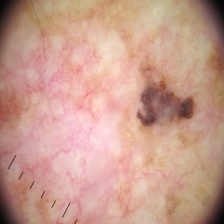

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
The lesion is classified as Melanoma.


In [ ]:
# Example usage for a mole we know is malignant
img_path =  '/content/drive/MyDrive/Colab Notebooks/train_cancer/malignant/33.jpg'
processed_image = preprocess_image(img_path)
display(Image(img_path))

# Predict the class
prediction = model.predict(processed_image)

# Interpret the result
if prediction[0] > 0.5:
    print('The lesion is classified as Melanoma.')
else:
    print('The lesion is classified as Not Melanoma.')

### b. Now let's use this model to predict whether a mole is benign or malignant for our entire testing dataset

The code below is assigning a true label (0 or 1) depending on which folder it is in (benign or malignant).

In [ ]:
classes = ['benign', 'malignant']  # 0 = not, 1 = melanoma
image_paths = []
labels = []

for label, class_name in enumerate(classes):
    class_dir = os.path.join(test_dir, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(class_dir, fname))
            labels.append(label)


The following code then uses the AI model calculate and then store its predictions so that we can compare what the model thinks to what the true label is.

`y_true` is an ordered list the true classification of the skin lesion.

`y_pred` is an ordered list of the predictions from the AI model.

`y_scores` is an ordered list of the probability calculated by the AI model that the lesion is melanoma or not melanoma. In the code below we specify that if the model calcualtes the probablity of the mole to be cancerous as > 0.5, we will classify it as melanoma. Although commonly set at 0.5, this threshold may be altered to improve algorithm performance as indicated.

In [ ]:
# FYI this code chunk will take about 10 minutes to run!

y_true = [] # true labels
y_pred = [] # predicted labels
y_scores = []  # Save probabilities for AUC

for img_path, true_label in zip(image_paths, labels):
    img = preprocess_image(img_path)
    prob = model.predict(img)[0][0]
    pred = int(prob > 0.5)

    y_true.append(true_label)
    y_pred.append(pred)
    y_scores.append(prob)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

## **Problem 1**: Calculating and interpreting performance metrics

### a. First let calculate a confusion matrix.
Using the function `confusion_matrix` and our `y_true` and `y_pred` variables, output the confusion matrix for this model. What do you notice about these values?

In [ ]:
#answer
print("\nConfusion Matrix:")
conf_matrix = (confusion_matrix(y_true, y_pred))
print(conf_matrix)


Confusion Matrix:
[[354   6]
 [246  54]]


### b. Accuracy
Using `y_true` and `y_scores`, calculate and interpret the accuracy of this model.

In [ ]:
#answer
print(f"Accuracy:  {accuracy_score(y_true, y_pred):.3f}")

Accuracy:  0.618


Also, calculate accuracy by hand using the confusion matrix. Do these values match?

### c. Precision
Using `y_true` and `y_scores`, calculate and interpret the precision of this model.

In [ ]:
print(f"Precision: {precision_score(y_true, y_pred):.3f}")

Precision: 0.900


Also, calculate precision by hand using the confusion matrix. Do these values match?

### d. Recall
Using `y_true` and `y_scores`, calculate and interpret the recall of this model.

In [ ]:
print(f"Recall:    {recall_score(y_true, y_pred):.3f}")

Recall:    0.180


Also, calculate recall by hand using the confusion matrix. Do these values match?

## **Problem 2**: AUC

### a. AUC
First, calculate and interpret the AUC of this model.

In [ ]:
print(f"AUC: {roc_auc_score(y_true, y_scores):.3f}")

AUC: 0.832


### b. Plots

Now use the following code to help you plot the ROC curve. What does the striaght blue line represent? What does the orange curve represent?

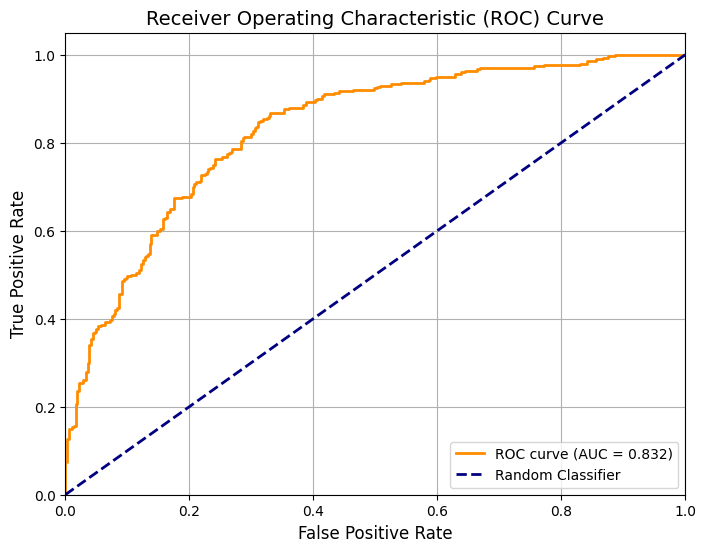

In [ ]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## **Problem 3**: Evaluation Bias and Fairness

### a. Results Interpretation

How does our AI model compare to a senior dermatologist?

Use this article to answer this question - article on human diagnostics accuracy of melanoma: https://pubmed.ncbi.nlm.nih.gov/9602875/#:~:text=A%20histopathological%20diagnosis%20of%20melanoma,positive%20predictive%20value%20of%2086%25.

### b. Evaluation bias

Take a closer look at the moles that this model has been trained on. What do you notice? How may evaluation bias be introduced?

### c. Fairness
Let's say someone recommends this model be use in a dermatology clinic. What concerns may you have in terms of fairness?